# Anomaly Detection: STEP1

## Outline
1. Introduction

2. Import Module

3. Load Dataset
    
    3.1 Description
    
    3.2 Define Anomalies
    
4. Split Dataset(Train, Test)

5. Exploratory Data Analysis

    5.1 Distribution
    
    5.2 Correlation

6. Implementation Anomaly Detection

## Introduction

[UCI machine learning repository](https://archive.ics.uci.edu/ml/index.php)의 갑상선 질환 데이터 셋을 이용하여 Point Anomalies를 탐지 구현을 목표로 하는 커널이다. 

데이터는 7200개의 행과 15개의 범주형 변수, 6개의 연속형 변수로 구성되어 있다. 이상 탐지 구현은 6개의 연속형 변수를 이용하여 구현할 것이다. 

라벨(class)은 정상데이터(Normal), 기능 항진(Hyperfunction)과 비정상(Subnormal)이 존재한다. 

훈련 데이터와 테스트 데이터로 분할되어 있지 않기 때문에 가장 먼저 분할을 수행한다.

## Import Module

In [87]:
import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.cof import COF
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.loci import LOCI

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [88]:
dataset = pd.read_csv('../dataset/thyroid_disease/thyroid_disease.csv')
dataset = dataset[['Age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'class']]
print('Dataset Shape:',dataset.shape)
dataset.head()

Dataset Shape: (7200, 7)


,Age,TSH,T3,TT4,T4U,FTI,class
0,0.73,0.00060,0.015,0.120,0.082,0.146,3
1,0.24,0.00025,0.030,0.143,0.133,0.108,3
2,0.47,0.00190,0.024,0.102,0.131,0.078,3
3,0.64,0.00090,0.017,0.077,0.090,0.085,3
4,0.23,0.00025,0.026,0.139,0.090,0.153,3


In [89]:
dataset.describe()

,Age,TSH,T3,TT4,T4U,FTI,class
count,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000
mean,0.520518,0.004861,0.019977,0.109430,0.097838,0.113215,2.902778
std,0.189269,0.022979,0.007539,0.035969,0.019085,0.036098,0.365923
min,0.010000,0.000000,0.000500,0.002000,0.017000,0.002000,1.000000
25%,0.370000,0.000710,0.017000,0.089000,0.087000,0.095000,3.000000
50%,0.550000,0.001700,0.020100,0.107000,0.097000,0.111000,3.000000
75%,0.670000,0.002700,0.022000,0.125000,0.104000,0.127000,3.000000
max,0.970000,0.530000,0.180000,0.600000,0.233000,0.642000,3.000000


### Description
연속형 변수와 라벨로 구성된 데이터의 설명은 다음과 같다.
- Age: 연령
- TSH: 갑상선 자극 호르몬 검사 수치
    - 뇌하수체에서 생성되는 호르몬 중 하나. 뇌하수체가 제대로 작동하지 않으면 TSH가 상승하거나 감소하게 된다. 
    - TSH 농도가 증가하면, 갑상선이 비정상적인 양의 T4(티록신),T3(트리요오드티로닌)의 생성과 분비를 자극한다.  
    - 시상하부, 뇌하수체, 갑상선 3개의 기관이 모두 정상적인 기능을 하고 있을 때, 혈중 갑상선 호르몬을 일정하기 유지하기 위해 호르몬 생산을 제어한다.
- T3: 트리요오드티로닌 검사 수치
- TT4: 티록신 검사 수치
- T4U: 티록신 흡수율 검사 수치
- FTI: 유리 티록신 지수
    - 총 티록신 수치에 영향을 줄 수 있는 특정 단백질의 변화를 교정하는 갑상선 기능을 평가하는 방법 중 하나.
    - 삼요오드티로닌 섭취율과 혈청 티록신의 농도를 곱한 임의의 값.

다음 표는 검사 결과와 검사 수치에 대한 의미를 요약해 놓은 것이다.

<img src="https://github.com/SSANGMAN/Anomaly_Detection/blob/master/image/TSH_T3_T4.PNG?raw=true" width="500">

Source: [Lab Tests Online](https://labtestsonline.kr/)

### Define Anomalies
데이터의 라벨은 총 3가지로 나뉘어 있다. 이상 감지는 일반적인 데이터 패턴에서 벗어나는 값을 찾는 것이기 때문에 대부분 Class Imblance 문제를 가지고 있다. 따라서 이상 클래스를 다음으로 정의한다.
- 1, 2: Hyperthyroidism(Anomalies)
- 3: Normal

In [90]:
dataset['outlier'] = dataset['class'].apply(lambda x: 0 if x == 3 else 1)
dataset.drop(columns = 'class', inplace = True)

X = dataset.drop(columns = 'outlier')
y = dataset['outlier']

## Split Dataset
이제, 데이터를 훈련 데이터와 테스트 데이터로 분할한다. 

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

## Exploratory Data Analysis
훈련 데이터에 대한 탐색적 자료 분석을 수행한다. 

분석을 수행하기 전 예상할 수 있는 가정은 다음과 같다.
- 정상 데이터와 이상 데이터의 컬럼별 분포는 상이할 것이다.

### Distribution

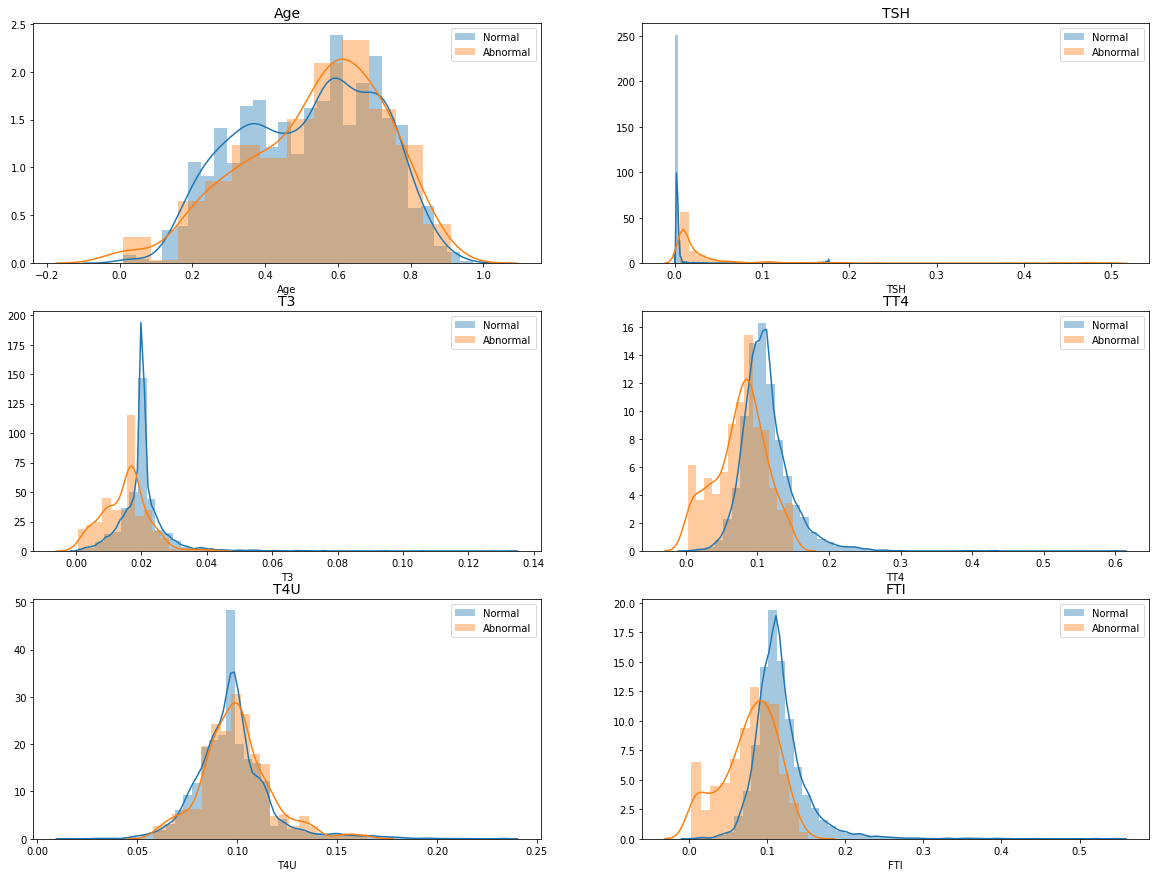

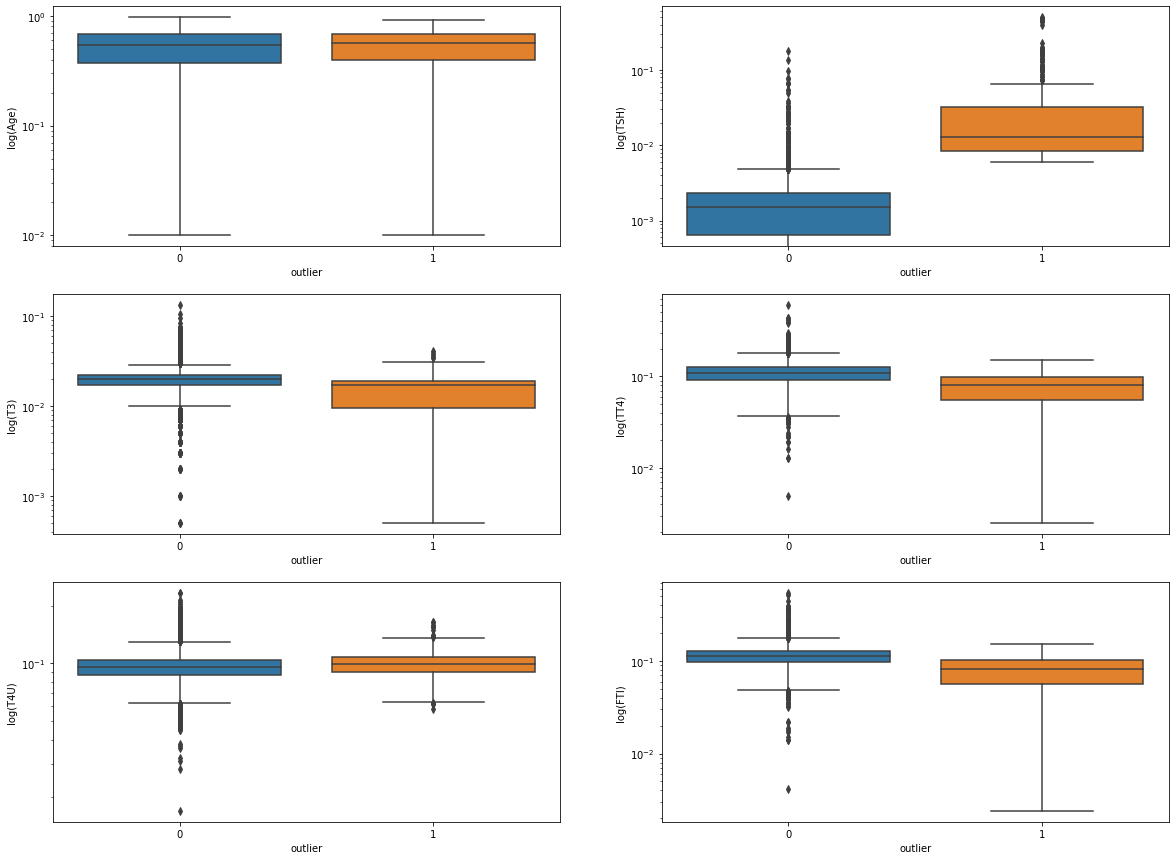

In [92]:
train = pd.concat([X_train, y_train], axis = 1)

f = plt.figure(figsize = (20, 15))

for i,col in enumerate(train.drop(columns = 'outlier').columns):
    f.add_subplot(3, 2, i+1)
    
    sns.distplot(train.loc[train['outlier'] == 0][col], label = "Normal")
    sns.distplot(train.loc[train['outlier'] == 1][col], label = "Abnormal")
    
    plt.title(col, fontsize = 14)
    plt.legend(loc = 'best')

f = plt.figure(figsize = (20, 15))

for i, col in enumerate(train.drop(columns = 'outlier').columns):
    f.add_subplot(3, 2, i+1)
    
    ax = sns.boxplot(x = "outlier", y = col, data = train)
    ax.set_yscale("log")
    ax.set_ylabel("log({})".format(col))

- 연령(Age)는 예상 외로 정상 그룹과 비정상 그룹이 큰 차이를 보이지 않는 것으로 나타났다.
- 갑상선 자극 호르몬 검사 수치(TSH)는 비정상 그룹의 분포가 정상 그룹의 분포보다 전체적으로 차이를 보이는 것으로 나타났다.
- 트리요오드티로닌 검사 수치(T3)는 비정상 그룹이 정상 그룹의 분포보다 다소 낮은 것으로 나타났지만 거의 차이를 보이지 않았다.
- 티록신 검사 수치(T4)는 비정상 그룹이 정상 그룹의 분포와 다소 차이를 보이는 것으로 나타났다.
- 티록신 흡수율 검사 수치(T4U)은 분포에서 거의 차이를 보이지 않았다.
- 유리 티록신 지수(FTI) 역시 비정상 그룹이 정상 그룹의 분포와 다소 차이를 보이는 것으로 나타났다.

T3와 TT4, FTI에서 정상 그룹과 비정상 그룹의 분포 차이가 비슷하다는 것을 알 수 있다.

### Correaltion

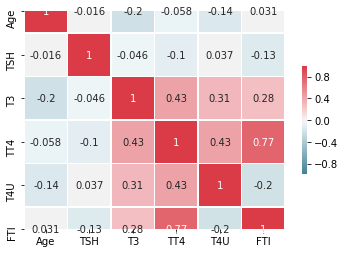

In [93]:
corr_normal = train.loc[train['outlier'] == 0].drop(columns = 'outlier').corr()
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr_normal, cmap = cmap, vmin = -1, vmax = 1, center = 0,
           square = True, linewidth = .5, cbar_kws = {'shrink': .5}, annot = True)

plt.show()

정상 그룹에 대한 변수간 상관관계를 확인해본 결과는 다음과 같다.
- 티록신 검사 수치(TT4)와 유리 티록신 지수(FTI)는 강한 양의 상관관계를 보인다는 것을 알 수 있다.
    - 유리 티록신 지수(FTI)는 삼요오드티로닌 섭취율과 티록신 검사 수치(T4)를 곱한 값이기 때문에 T4의 선형 이동 변수라고 볼 수 있다.
- 트리요오드티로닌 검사 수치(T3)와 티록신 검사 수치(TT4)는 약한 양의 상관관계를 보인다는 것을 알 수 있다.
- 티록신 검사 수치(TT4)와 티록신 흡수율 검사 수치(F4U)는 약한 양의 상관관계를 보인다는 것을 알 수 있다.

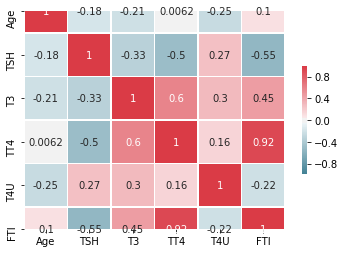

In [94]:
corr_normal = train.loc[train['outlier'] == 1].drop(columns = 'outlier').corr()
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr_normal, cmap = cmap, vmin = -1, vmax = 1, center = 0,
           square = True, linewidth = .5, cbar_kws = {'shrink': .5}, annot = True)

plt.show()

비정상 그룹에 대한 변수간 상관관계를 확인해본 결과는 다음과 같다.
- 티록신 검사 수치(TT4)와 유리 티록신 지수(FTI)는 매우 강한 양의 상관관계를 보인다는 것을 알 수 있다. 이는 정상 그룹의 상관관계보다 더 강하게 나타난다.
- 트리요오드티로닌 검사 수치(T3)와 티록신 검사 수치(TT4)는 양의 상관관계를 보인다는 것을 알 수 있다. 이는 정상 그룹의 상관관계보다 더 강하게 나타난다.

정상 그룹과 비교하여 뚜렷한 차이를 보이는 상관관계도 존재했다.
- 갑상선 자극 호르몬 검사 수치(TSH)와 티록신 검사 수치(TT4)는 음의 상관관계를 보인다는 것을 알 수 있다.
    - TSH와 TT4는 반비례 관계를 보인다. 이는 갑상선 기능 저하증의 특징이다.
- 갑상선 자극 호르몬 검사 수치(TSH)와 유리 티록신 지수(FTI)는 음의 상관관계를 보인다는 것을 알 수 있다.
    - FTI는 TT4의 선형 이동 변수이기 때문에 나타나는 것으로 보인다.

## Implementation Anomaly Detection
이제, Nearest Neighbor 기반 이상 탐지 기법을 이용한 이상 탐지 기법을 구현한다. 구현 알고리즘은 다음과 같다.

- KNN(K Nearest Neighbor)
- LOF(Local Outlier Factor)
- COF(Connectivity-Based Outlier Factor)
- CBLOF(Clustering-Based Local Outlier Factor)

훈련 데이터에서 이상값으로 판단한 outlier = 1의 비율을 contamination 비율로 지정한 후, 이상 탐지 알고리즘을 이용한 예측값과 비교한다.

In [95]:
contamination = np.unique(y_train, return_counts = True)[1][1]/len(y_train)
print("Contamination Rate: {}%".format(contamination*100))

Contamination Rate: 7.203703703703704%


### KNN

In [96]:
clf = KNN(contamination = contamination)
clf.fit(X_train)

y_pred = clf.predict(X_test)
print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy: 89.55555555555556%


In [97]:
knn_y_pred_proba = clf.predict_proba(X_test)[::,1]

test_predict = pd.DataFrame(y_test)
test_predict['knn_pred'] = knn_y_pred_proba

In [98]:
confusion_matrix(test_predict['outlier'], y_pred)

array([[1568,   87],
       [ 101,   44]], dtype=int64)

### AvgKNN

In [99]:
clf = KNN(contamination = contamination, method = 'mean')
clf.fit(X_train)

y_pred = clf.predict(X_test)
print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy: 89.22222222222223%


In [100]:
avgknn_y_pred_proba = clf.predict_proba(X_test)[::,1]

test_predict['Avgknn_pred'] = avgknn_y_pred_proba

In [101]:
confusion_matrix(test_predict['outlier'], y_pred)

array([[1565,   90],
       [ 104,   41]], dtype=int64)

### MedianKNN

In [102]:
clf = KNN(contamination = contamination, method = 'median')
clf.fit(X_train)

print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy: 89.22222222222223%


In [103]:
medianknn_y_pred_proba = clf.predict_proba(X_test)[::,1]

test_predict['medianknn_pred'] = medianknn_y_pred_proba

In [104]:
confusion_matrix(test_predict['outlier'], y_pred)

array([[1565,   90],
       [ 104,   41]], dtype=int64)

### Local Outlier Factor

In [105]:
clf = LOF(contamination = contamination)
clf.fit(X_train)

y_pred = clf.predict(X_test)
print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy: 88.38888888888889%


In [106]:
lof_y_pred_proba = clf.predict_proba(X_test)[::,1]

test_predict['lof_pred'] = lof_y_pred_proba

In [107]:
confusion_matrix(test_predict['outlier'], y_pred)

array([[1546,  109],
       [ 100,   45]], dtype=int64)

### Connectivity-Based Outlier Factor(COF)

In [108]:
clf = COF(contamination = contamination)
clf.fit(X_train)

y_pred = clf.predict(X_test)
print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy: 86.8888888888889%


In [109]:
cof_y_pred_proba = clf.predict_proba(X_test)[::,1]

test_predict['cof_pred'] = cof_y_pred_proba

In [110]:
confusion_matrix(test_predict['outlier'], y_pred)

array([[1519,  136],
       [ 100,   45]], dtype=int64)

### Clustering-Based Outlier Factor(CBLOF)

In [111]:
clf = CBLOF(contamination = contamination)
clf.fit(X_train)

y_pred = clf.predict(X_test)
print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy: 88.61111111111111%


In [112]:
cblof_y_pred_proba = clf.predict_proba(X_test)[::,1]

test_predict['cblof_pred'] = cblof_y_pred_proba

In [113]:
confusion_matrix(test_predict['outlier'], y_pred)

array([[1558,   97],
       [ 108,   37]], dtype=int64)

### HBOS(Histogram-Based Outlier Score)

In [114]:
clf = HBOS(contamination = contamination)
clf.fit(X_train)

y_pred = clf.predict(X_test)
print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy: 89.5%


In [115]:
hbos_y_pred_proba = clf.predict_proba(X_test)[::,1]

test_predict['hbos_pred'] = hbos_y_pred_proba

In [116]:
confusion_matrix(test_predict['outlier'], y_pred)

array([[1570,   85],
       [ 104,   41]], dtype=int64)

## Proximity-Based ROC AUC Curve

In [127]:
def roc_auc_curve(test_data, methods = test_predict.columns[1:]):
    plt.figure(figsize = (6,6))
    for method,i in enumerate(methods):
        fpr, tpr, _ = roc_curve(test_data['outlier'], test_predict[i])
        auc = roc_auc_score(test_data['outlier'], test_predict[i])
    
        plt.plot(fpr, tpr, label = test_predict.columns[1:][method].split("_")[0].upper() + ", auc = {}".format(auc))
        plt.legend()

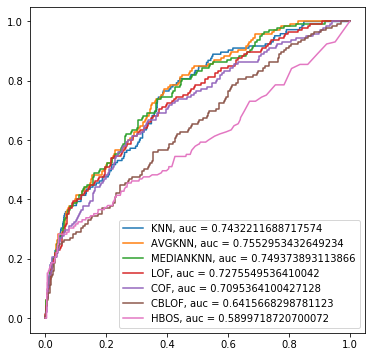

In [128]:
roc_auc_curve(test_predict)